<h1>contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#tl;dr" data-toc-modified-id="tl;dr-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>tl;dr</a></span></li><li><span><a href="#setup" data-toc-modified-id="setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>setup</a></span></li><li><span><a href="#neural-network-architecture" data-toc-modified-id="neural-network-architecture-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>neural network architecture</a></span></li><li><span><a href="#data" data-toc-modified-id="data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#training" data-toc-modified-id="training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>training</a></span></li><li><span><a href="#results" data-toc-modified-id="results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>results</a></span></li></ul></div>

# tl;dr

In this notebook we will try to make some experiments with the **Damped Harmonic Oscillator** (DHO) synthetic data. Here the goal is to vary some hyperparameters and see how the model behaves in terms interpolation -- rather than extrapolation.

# setup

In [1]:
import pprint
import functools
import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from IPython.display import display

%matplotlib inline

# neural network architecture

In [61]:
class MultiLayerPerceptronRegressor(nn.Module):
    """
    feedforward neural network regressor
    """
    def __init__(self, layers:list, activation:torch.nn.modules.activation):
        super(MultiLayerPerceptronRegressor, self).__init__()
        _architecture = list()

        for index, layer in enumerate(layers[:-2]):
            _architecture.append(nn.Linear(layer, layers[index+1]))
            _architecture.append(activation())
        _architecture.append(nn.Linear(layers[-2], layers[-1]))
        
        self.architecture = nn.Sequential(*_architecture)

    def forward(self, x):
        return self.architecture(x)

torch.manual_seed(33) ;


$$ \ddot{x} + \frac{\mu}{m} \dot{x} + \frac{k}{m} x = 0 $$

# data

,time,displacement
0,0.000000,1.000000
1,0.040080,0.711022
2,0.080160,0.064829
3,0.120240,-0.522116
4,0.160321,-0.728375


<Axes: title={'center': 'Damped Harmonic Oscillator'}, xlabel='time'>

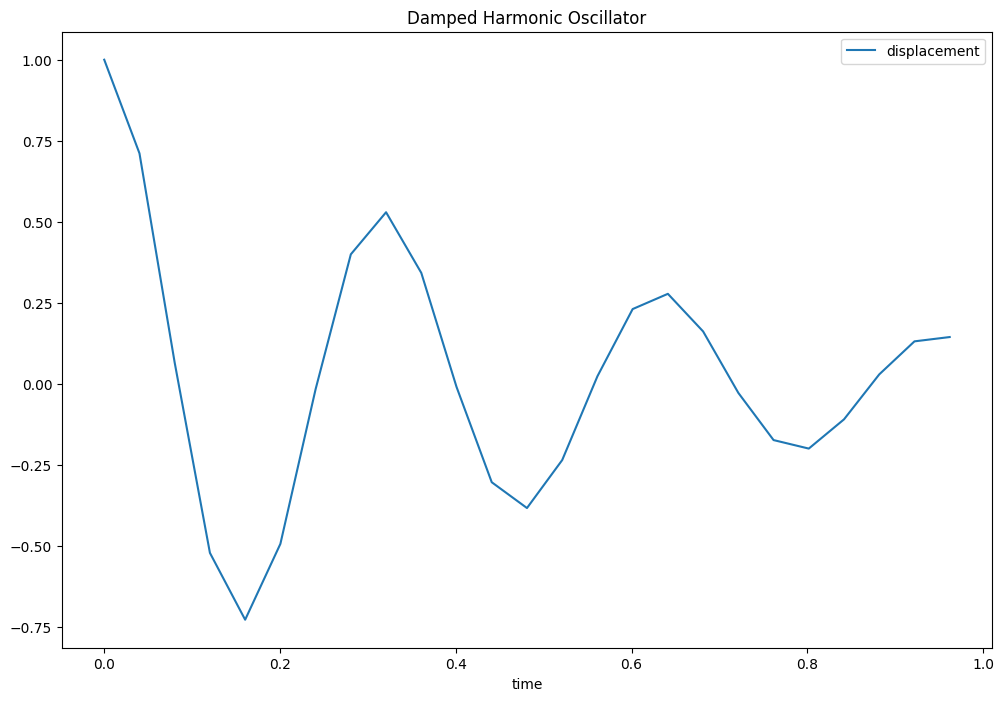

In [107]:
X = pd.read_csv("../data/01_raw/damped-harmonic-oscillator/extrapolation/train.csv").query("time <= 50")

# min_max_scaler = MinMaxScaler()
# X["time"] = min_max_scaler.fit_transform(X["time"].values.reshape(-1, 1))

def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y


d, w0 = 2, 20
x = torch.linspace(0, 1, 500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)

X = pd.DataFrame({"time": x.squeeze()[0:500:20], "displacement": y.squeeze()[0:500:20]})

display(X.head())

X.plot(x="time", y="displacement", figsize=(12, 8), title="Damped Harmonic Oscillator")

# training

MultiLayerPerceptronRegressor(
  (architecture): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


  3%|▎         | 1026/30000 [00:03<02:09, 224.05it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.017074, Physics Loss: 346.528229, x0 Loss: 0.035310, v0 Loss: 0.182269, Total Loss: 0.051944


  7%|▋         | 2024/30000 [00:08<02:24, 193.06it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.002529, Physics Loss: 177.425232, x0 Loss: 0.003625, v0 Loss: 0.000025, Total Loss: 0.020276


 10%|█         | 3033/30000 [00:14<02:21, 190.26it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000344, Physics Loss: 87.516151, x0 Loss: 0.000472, v0 Loss: 0.000007, Total Loss: 0.009096


 13%|█▎        | 4044/30000 [00:17<01:53, 229.62it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000314, Physics Loss: 83.780540, x0 Loss: 0.000432, v0 Loss: 0.000140, Total Loss: 0.008692


 17%|█▋        | 5040/30000 [00:22<01:30, 275.09it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000286, Physics Loss: 79.537102, x0 Loss: 0.000389, v0 Loss: 0.000082, Total Loss: 0.008240


 20%|██        | 6032/30000 [00:26<01:45, 228.05it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000355, Physics Loss: 82.474327, x0 Loss: 0.000068, v0 Loss: 0.000100, Total Loss: 0.008602


 23%|██▎       | 7022/30000 [00:30<01:42, 223.80it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000217, Physics Loss: 66.636063, x0 Loss: 0.000289, v0 Loss: 0.000001, Total Loss: 0.006881


 27%|██▋       | 8030/30000 [00:35<01:36, 228.56it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000164, Physics Loss: 54.970200, x0 Loss: 0.000207, v0 Loss: 0.000160, Total Loss: 0.005661


 30%|███       | 9039/30000 [00:39<01:34, 221.86it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000087, Physics Loss: 34.766205, x0 Loss: 0.000106, v0 Loss: 0.001478, Total Loss: 0.003565


 33%|███▎      | 10022/30000 [00:44<01:41, 197.40it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000022, Physics Loss: 8.000955, x0 Loss: 0.000015, v0 Loss: 0.005441, Total Loss: 0.000827


 37%|███▋      | 11045/30000 [00:49<00:59, 319.07it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000079, Physics Loss: 18.334888, x0 Loss: 0.000123, v0 Loss: 0.006629, Total Loss: 0.001919


 40%|████      | 12031/30000 [00:53<01:25, 209.54it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000004, Physics Loss: 2.747160, x0 Loss: 0.000000, v0 Loss: 0.004497, Total Loss: 0.000284


 43%|████▎     | 13037/30000 [00:58<01:24, 201.29it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000003, Physics Loss: 2.606011, x0 Loss: 0.000000, v0 Loss: 0.002644, Total Loss: 0.000266


 47%|████▋     | 14020/30000 [01:03<01:19, 201.47it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000075, Physics Loss: 36.280483, x0 Loss: 0.000003, v0 Loss: 0.008482, Total Loss: 0.003711


 50%|█████     | 15038/30000 [01:08<01:12, 205.27it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000004, Physics Loss: 3.715461, x0 Loss: 0.000001, v0 Loss: 0.001700, Total Loss: 0.000377


 53%|█████▎    | 16041/30000 [01:12<00:51, 268.62it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000001, Physics Loss: 2.470300, x0 Loss: 0.000001, v0 Loss: 0.000726, Total Loss: 0.000249


 57%|█████▋    | 17030/30000 [01:17<01:04, 199.70it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000001, Physics Loss: 2.437375, x0 Loss: 0.000001, v0 Loss: 0.000471, Total Loss: 0.000245


 60%|██████    | 18035/30000 [01:21<00:37, 322.89it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000001, Physics Loss: 2.476287, x0 Loss: 0.000002, v0 Loss: 0.000217, Total Loss: 0.000249


 63%|██████▎   | 19038/30000 [01:25<00:53, 205.18it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000001, Physics Loss: 2.347285, x0 Loss: 0.000001, v0 Loss: 0.000173, Total Loss: 0.000236


 67%|██████▋   | 20036/30000 [01:30<00:51, 193.41it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000005, Physics Loss: 2.767876, x0 Loss: 0.000010, v0 Loss: 0.000003, Total Loss: 0.000282


 70%|███████   | 21023/30000 [01:35<00:44, 201.29it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000001, Physics Loss: 2.355974, x0 Loss: 0.000002, v0 Loss: 0.000015, Total Loss: 0.000237


 73%|███████▎  | 22034/30000 [01:40<00:34, 230.37it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000009, Physics Loss: 6.304617, x0 Loss: 0.000006, v0 Loss: 0.000237, Total Loss: 0.000639


 77%|███████▋  | 23030/30000 [01:45<00:35, 196.31it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000009, Physics Loss: 4.795701, x0 Loss: 0.000004, v0 Loss: 0.000385, Total Loss: 0.000489


 80%|████████  | 24051/30000 [01:49<00:17, 335.77it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000001, Physics Loss: 2.116450, x0 Loss: 0.000002, v0 Loss: 0.000000, Total Loss: 0.000213


 83%|████████▎ | 25019/30000 [01:54<00:26, 188.19it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000002, Physics Loss: 2.771706, x0 Loss: 0.000005, v0 Loss: 0.000014, Total Loss: 0.000279


 87%|████████▋ | 26030/30000 [01:59<00:19, 201.50it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000001, Physics Loss: 2.009017, x0 Loss: 0.000002, v0 Loss: 0.000008, Total Loss: 0.000202


 90%|█████████ | 27047/30000 [02:03<00:08, 342.24it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000001, Physics Loss: 1.951712, x0 Loss: 0.000002, v0 Loss: 0.000012, Total Loss: 0.000196


 94%|█████████▎| 28054/30000 [02:06<00:05, 341.42it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000003, Physics Loss: 2.526389, x0 Loss: 0.000003, v0 Loss: 0.000118, Total Loss: 0.000255


 97%|█████████▋| 29024/30000 [02:10<00:04, 202.65it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000001, Physics Loss: 2.068898, x0 Loss: 0.000002, v0 Loss: 0.000000, Total Loss: 0.000208


100%|██████████| 30000/30000 [02:15<00:00, 221.33it/s]


mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000003, Physics Loss: 2.345663, x0 Loss: 0.000002, v0 Loss: 0.000156, Total Loss: 0.000237


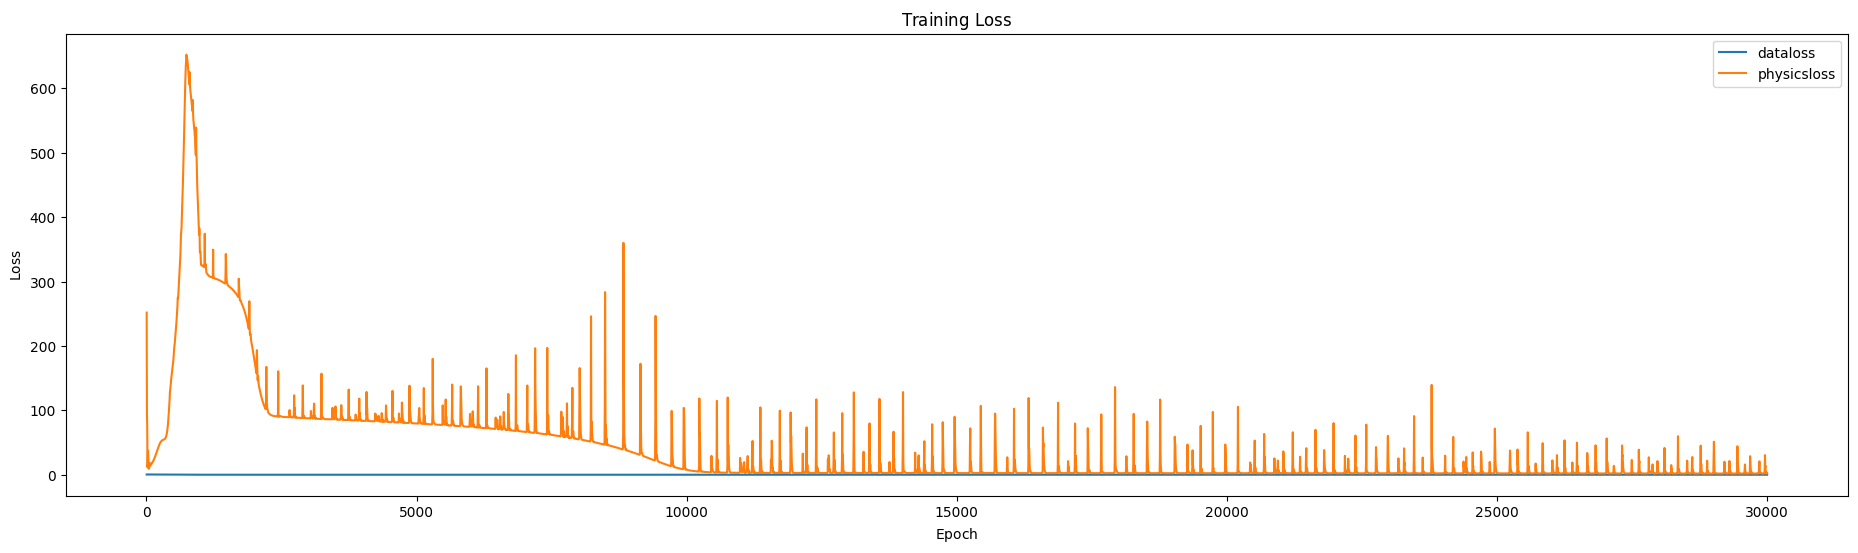

In [113]:
m = 1
# k = 1
# mu = 0.1
mu, k = 2*d, w0**2
x_0 = 1
v_0 = 0

torch.manual_seed(123)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x_train = torch.tensor(X.query("time <= 0.3")["time"].values).float().unsqueeze(1).to(device)
y_train = torch.tensor(X.query("time <= 0.3")["displacement"].values).float().unsqueeze(1).to(device)

x_test = torch.tensor(X.query("time > 0.3")["time"].values).float().unsqueeze(1).to(device)
y_test = torch.tensor(X.query("time > 0.3")["displacement"].values).float().unsqueeze(1).to(device)

hparam_dict = {
    'learning_rate': 1e-3,
    'n_layers': 3,
    'n_neurons': 32,
    'num_epochs': 30000,
 }

learning_rate = hparam_dict["learning_rate"]
num_epochs = hparam_dict["num_epochs"]
architecture = [1] + [hparam_dict["n_neurons"] for _ in range(hparam_dict["n_layers"])] + [1]

model = MultiLayerPerceptronRegressor(architecture, nn.Tanh)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

print(model)

plot_loss_train = dict(epoch=[], dataloss=[], physicsloss=[])

_locations = torch.linspace(0, 1, 30).view(-1,1).requires_grad_(True).to(device)
_m = torch.tensor(m, dtype=torch.float, requires_grad=False).to(device)
_mu = torch.tensor(mu, dtype=torch.float, requires_grad=False).to(device)
_k = torch.tensor(k, dtype=torch.float, requires_grad=False).to(device)
_x0 = torch.tensor(x_0, dtype=torch.float, requires_grad=False).to(device)
_v0 = torch.tensor(v_0, dtype=torch.float, requires_grad=False).to(device)

for epoch in tqdm.tqdm(range(hparam_dict["num_epochs"])):
    optimizer.zero_grad()

    # forward
    y_train_hat = model(x_train)
    data_loss = criterion(y_train_hat, y_train)

    y_location_hat = model(_locations)
    dydt = torch.autograd.grad(y_location_hat, _locations, grad_outputs=torch.ones_like(y_location_hat), create_graph=True)[0]
    dy2dt2 = torch.autograd.grad(dydt, _locations, grad_outputs=torch.ones_like(dydt), create_graph=True)[0]

    _x0_loss = criterion(y_location_hat[0], _x0)
    _v0_loss = criterion(dydt[0], _v0)

    _diff_equation = _m*dy2dt2 + _mu*dydt + _k*y_location_hat
    
    physics_loss = criterion(_diff_equation, torch.zeros_like(_diff_equation))

    loss = data_loss + (1e-4)*(physics_loss) + (1e-3)*(_x0_loss) + (1e-3)*(_v0_loss)
    
    # backward
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1000 == 0:
        str_epoch = str(epoch+1).zfill(5)
        str_num_epochs = str(num_epochs).zfill(5)
        str_loss = str(round(loss.item(), 4))
        str_physics_loss = str(round(physics_loss.item(), 4))
        # print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss} physics loss: {str_physics_loss}")
        print("mass = ", _m.item(), "damping = ", _mu.item(), "spring = ", _k.item())
        print(f"Data Loss: {data_loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}, x0 Loss: {_x0_loss.item():.6f}, v0 Loss: {_v0_loss.item():.6f}, Total Loss: {loss.item():.6f}")

    if (epoch+1) % 5 == 0:
        plot_loss_train["epoch"].append(epoch+1)
        plot_loss_train["dataloss"].append(data_loss.item())
        plot_loss_train["physicsloss"].append(physics_loss.item())

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

pd.DataFrame(plot_loss_train).plot(x="epoch", y="dataloss", figsize=(23, 6), ax=ax1)
pd.DataFrame(plot_loss_train).plot(x="epoch", y="physicsloss", figsize=(23, 6), ax=ax1)
ax1.set_xlabel(r"$\mathrm{Epoch}$")
ax1.set_ylabel(r"$\mathrm{Loss}$")
ax1.set_title(r"$\mathrm{Training}$ $\mathrm{Loss}$")

plt.savefig("../data/08_reporting/figures/oscilador_harmonico_loss_pinn.png", dpi=300, bbox_inches="tight") ;

# results

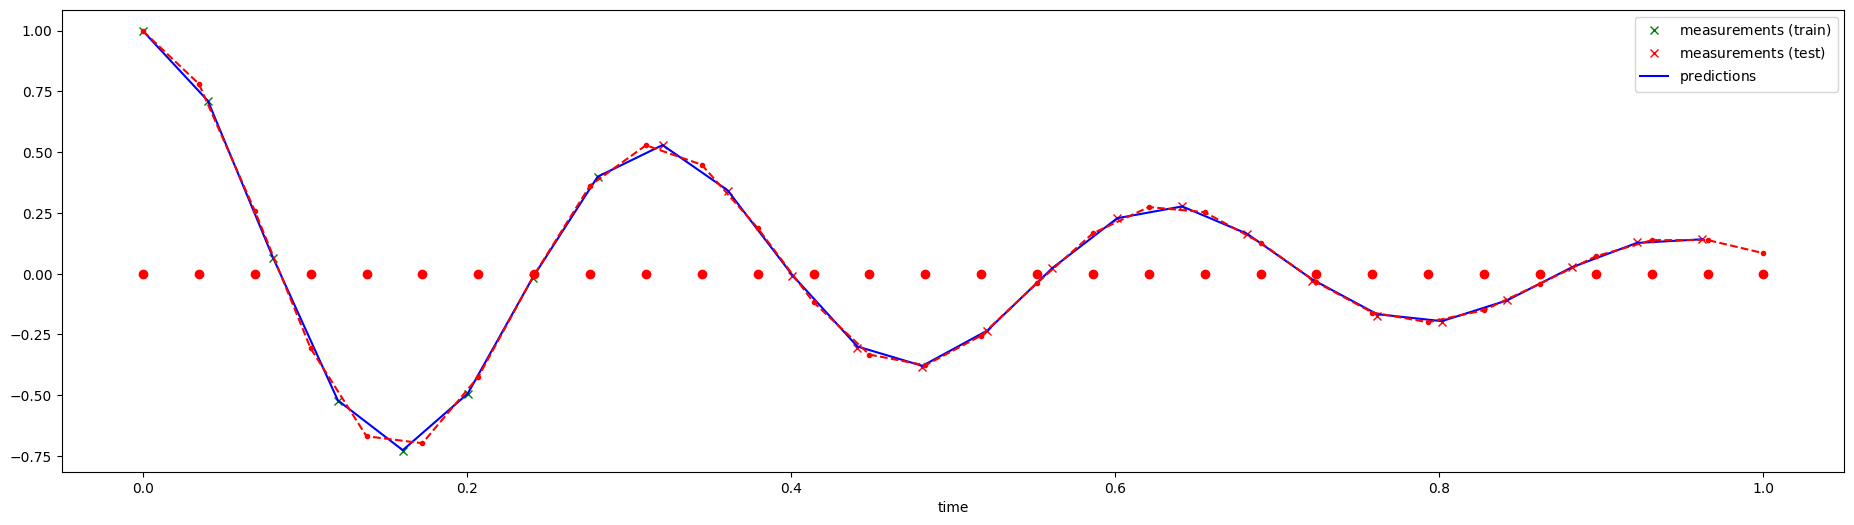

In [117]:
model.eval()

with torch.no_grad():
    X["y_hat"] = model(torch.tensor(X["time"].values).float().unsqueeze(1).to(device)).cpu().detach().numpy()

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

X.query("time <= 0.3").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="g", linestyle="none", 
    label=r"$\text{measurements (train)}$"
)

X.query("time > 0.3").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="r", linestyle="none", 
    label=r"$\text{measurements (test)}$"
)

X.plot(
    x="time", 
    y="y_hat", 
    ax=ax1,
    c="b", linestyle="-", 
    label=r"$\text{predictions}$"
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1)*0, 
    c="r", linestyle="none", marker="o",
    label=r"$\text{locations}$"
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1), 
    c="r", linestyle="--", marker=".",
    label=r"$\text{locations prediction}$"
)

# # plot theoretical curve
# m = 1
# k = 1
# mu = 0.1
# x_0 = 1
# v_0 = 0

# omega_0 = np.sqrt(k/m)
# delta = mu/(2*m)
# omega = np.sqrt(omega_0**2 - delta**2)

# t = np.linspace(0, 50, 1000)
# x = np.exp(-delta*t)*(x_0*np.cos(omega*t) + (v_0 + delta*x_0)/omega*np.sin(omega*t))
# ax1.plot(
#     t.reshape(-1, 1),
#     x, 
#     c="k", linestyle="--", 
#     label=r"$\text{exact solution}$"
# )

# ax1.set_xlabel(r"$\mathrm{time}$ $\mathrm{(s)}$")
# ax1.set_ylabel(r"$\mathrm{displacement}$ $\mathrm{(m)}$")
# ax1.set_title(r"$\mathrm{Damped}$ $\mathrm{Harmonic}$ $\mathrm{Oscillator}$")

# plt.suptitle(f"MSE = {round(mean_squared_error(X['displacement'], X['y_hat']), 4)}")
# ax1.legend()

# plt.savefig("../data/08_reporting/figures/oscilador_harmonico_predictions_pinn.png", dpi=300, bbox_inches="tight") ;

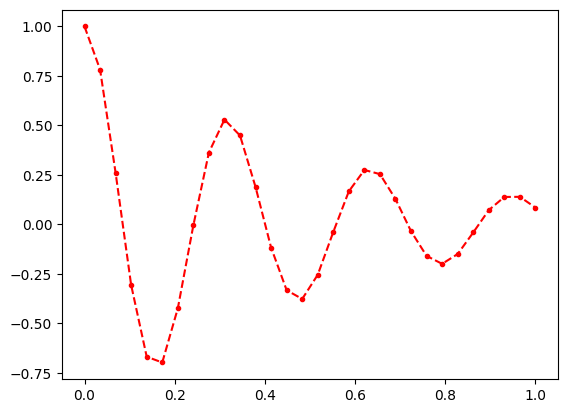

In [118]:
model.eval()
with torch.no_grad():
    plt.plot(
        _locations.cpu().detach().numpy().reshape(-1, 1),
        model(_locations).cpu().detach().numpy().reshape(-1), 
        c="r", linestyle="--", marker=".",
        label=r"$\text{locations prediction}$"
    )

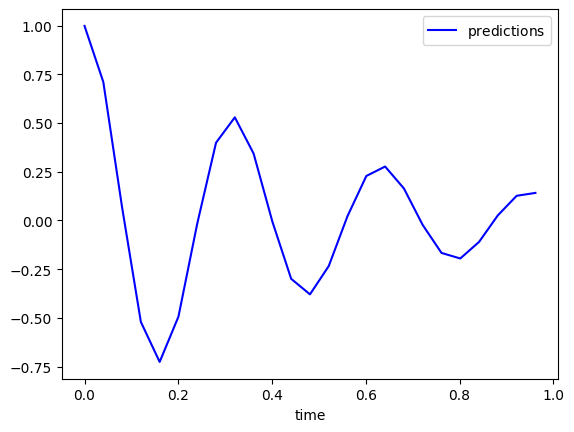

In [119]:
X.plot(
    x="time", 
    y="y_hat",
    c="b", linestyle="-", 
    label=r"$\text{predictions}$"
) ;

.